In [1]:
import numpy as np, curvedsky as cs, plottools as pl, cmb as CMB
from matplotlib.pyplot import *

In [2]:
def noise(lcl,sig,theta,alpha,split=False):
    nl = np.zeros((4,rlmax+1))
    nl[0,:] = .5*(sig*ac2rad/Tcmb)**2*np.exp(L*(L+1)*(theta*ac2rad)**2/8./np.log(2.))
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    if split: nl *= 2.
    Lcl = lcl.copy()
    Lcl[2,:] *= alpha
    return Lcl + nl

In [3]:
def rec(Lmax,rlmin,rlmax,lcl,ocl):
    Ag = {}
    #Ag['TE'] = cs.norm_imag.qte('lens',Lmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[1,:])[0]
    #Ag['TB'] = cs.norm_imag.qtb('lens',Lmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[2,:])[0]
    #Ag['EE'] = cs.norm_imag.qee('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:])[0]
    Ag['EB'] = cs.norm_imag.qeb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])[0]
    Ag['BB'] = cs.norm_imag.qbb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[2,:])[0]
    return Ag

In [4]:
def snr_ilens(Ag,ucl,L,corr=1.):
    Nl = 1./(1./Ag['EB']+1./Ag['BB'])
    #Nl = 1./(1./Ag['EB']+1./Ag['TB']+1./Ag['BB'])
    #Nl = 1./(1./Ag['EB']+1./Ag['TB']+1./Ag['BB']+1./Ag['EE']+1./Ag['TE'])
    SN = (2*L+1.)*ucl[3]/Nl * corr**2
    sn = np.pi/180. * np.sqrt( np.sum(SN[2:]) )
    return sn

In [5]:
def snr_eb(lcl,ocl,L,rlmin):
    SN = (2*L+1.)*(lcl[1,:]-lcl[2,:])**2/( ocl[1,:]*ocl[2,:] )
    sn = np.pi/180. * 2. * np.sqrt( np.sum(SN[rlmin+1:]) )
    return sn

In [6]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 4000       # maximum multipole of output normalization
rlmin, rlmax = 100, Lmax  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
ac2rad = np.pi/10800.
sigs  = np.array([70.,15.,5.,3.,2.,1.,.5])
alpha = np.array([1.,1.,1.,.5,.3,.2,.1])
thetas = np.array([30.,7.,3.,.5])

In [7]:
ucl = CMB.read_camb_cls('data_local/cosmo2017_10K_acc3_scalCls.dat',output='array')[:,:Lmax+1]
lcl = CMB.read_camb_cls('data_local/cosmo2017_10K_acc3_lensedCls.dat',ftype='lens',output='array')[:,:Lmax+1]

In [8]:
snr_cib = np.zeros((2,len(thetas),len(sigs)))
snr_inp = np.zeros((2,len(thetas),len(sigs)))
snr_cEB = np.zeros((2,len(thetas),len(sigs)))
for j, theta in enumerate(thetas):
    for i, sig in enumerate(sigs):
        print(i,j)
        ocl0 = noise(lcl,sig,theta,alpha[i])
        ocl1 = noise(lcl,sig,theta,alpha[i],split=False)
        Ag  = rec(Lmax,rlmin,rlmax,lcl,ocl0)
        snr_cib[0,j,i] = alpha[i]**.5*snr_ilens(Ag,ucl,L,corr=(0.4-0.9)/(2000.)*L+0.9)
        snr_inp[0,j,i] = alpha[i]**.5*snr_ilens(Ag,ucl,L)
        snr_cEB[0,j,i] = snr_eb(lcl,ocl1,L,rlmin)

0 0


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


1 0
2 0
3 0
4 0
5 0
6 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3


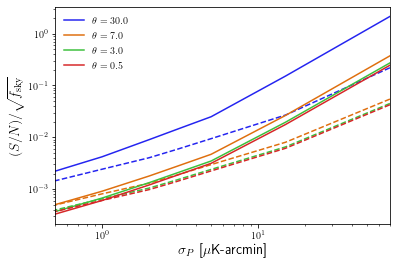

In [9]:
pl.plot_1dstyle(usetex=True,xmin=.5,xmax=70,xlog=True,ylog=True,xlab='$\sigma_P$ [$\mu$K-arcmin]',ylab=r'$(S/N)/\sqrt{f_{\rm sky}}$')
for j, theta in enumerate(thetas):
    p0, = plot(sigs,1./snr_inp[0,j,:],ls='-',label=r'$\theta='+str(theta)+'$')
    plot(sigs,1./snr_cEB[0,j,:],color=p0.get_color(),ls='--')
legend()
savefig('fig_const_delens.pdf')